In [52]:
import pandas as pd
import numpy as np
import shutil
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD

In [2]:
%cd /content

!unzip -qq "/content/drive/MyDrive/KDEF_Pose_V2.zip"

/content


In [3]:
!unzip -qq "/content/drive/MyDrive/KDEF_Angle2_V2.zip"

In [4]:
!unzip -qq "/content/drive/MyDrive/KDEF_All_V2.zip"

# Load Data

In [53]:
# 불필요한 폴더 삭제
if os.path.exists("/content/KDEF_Pose_V2/Train/.ipynb_checkpoints"):
    shutil.rmtree("/content/KDEF_Pose_V2/Train/.ipynb_checkpoints")

if os.path.exists("/content/KDEF_Pose_V2/Test/.ipynb_checkpoints"):
    shutil.rmtree("/content/KDEF_Pose_V2/Test/.ipynb_checkpoints")

In [54]:
# 불필요한 폴더 삭제
if os.path.exists("/content/KDEF_Angle2_V2/Train/.ipynb_checkpoints"):
    shutil.rmtree("/content/KDEF_Angle2_V2/Train/.ipynb_checkpoints")

if os.path.exists("/content/KDEF_Angle2_V2/Test/.ipynb_checkpoints"):
    shutil.rmtree("/content/KDEF_Angle2_V2/Test/.ipynb_checkpoints")

In [55]:
TEST_DIR = '/content/KDEF_All_V2/Test/'

In [56]:
POSE_TEST_DIR = '/content/KDEF_Pose_V2/Test/'

In [57]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        if label == '.DS_Store':
            continue
        for filename in os.listdir(directory+label):
            if filename == '.DS_Store':
                continue
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [58]:
from google.colab import data_table
from vega_datasets import data

data_table.enable_dataframe_formatter()

In [59]:
pose_test = pd.DataFrame()
pose_test['image'], pose_test['label'] = load_dataset(POSE_TEST_DIR)
pose_test

side Completed
straight Completed


image     label
0          /content/KDEF_Pose_V2/Test/side/BF08ANHL.JPG      side
1      /content/KDEF_Pose_V2/Test/side/BF06ANFL_AUG.jpg      side
2      /content/KDEF_Pose_V2/Test/side/BF03SUFR_AUG.jpg      side
3      /content/KDEF_Pose_V2/Test/side/AF07DIFR_AUG.jpg      side
4          /content/KDEF_Pose_V2/Test/side/BF08DIFL.JPG      side
...                                                 ...       ...
2795    /content/KDEF_Pose_V2/Test/straight/AF07SAS.JPG  straight
2796  /content/KDEF_Pose_V2/Test/straight/BM01DIS_AU...  straight
2797    /content/KDEF_Pose_V2/Test/straight/BF01NES.JPG  straight
2798  /content/KDEF_Pose_V2/Test/straight/BM03SAS_AU...  straight
2799    /content/KDEF_Pose_V2/Test/straight/BM04HAS.JPG  straight

[2800 rows x 2 columns]

In [60]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0     /content/KDEF_All_V2/Test/surprised/BF03SUFR_A...  surprised
1       /content/KDEF_All_V2/Test/surprised/AM04SUS.JPG  surprised
2      /content/KDEF_All_V2/Test/surprised/BM05SUHR.JPG  surprised
3      /content/KDEF_All_V2/Test/surprised/AF01SUFR.JPG  surprised
4      /content/KDEF_All_V2/Test/surprised/BF08SUFL.JPG  surprised
...                                                 ...        ...
2795      /content/KDEF_All_V2/Test/afraid/BM07AFHR.JPG     afraid
2796      /content/KDEF_All_V2/Test/afraid/AF07AFHR.JPG     afraid
2797  /content/KDEF_All_V2/Test/afraid/BF03AFFR_AUG.jpg     afraid
2798  /content/KDEF_All_V2/Test/afraid/BF02AFFR_AUG.jpg     afraid
2799  /content/KDEF_All_V2/Test/afraid/AM04AFFL_AUG.jpg     afraid

[2800 rows x 2 columns]

# Define Feature Extraction Method

In [61]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
        img = np.array(cropped_img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 300, 224, 1)
    print(features.shape)
    return features

# 🧑 Straight Model 


> Straight 사진만 학습할 모델

---





In [65]:
TRAIN_DIR = '/content/drive/MyDrive/KDEF_Angle2_V2/Train/straight/'

In [66]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

disgusted Completed
surprised Completed
neutral Completed
afraid Completed
happy Completed
angry Completed
sad Completed


image    label
0  /content/drive/MyDrive/KDEF_Angle2_V2/Train/st...    happy
1  /content/drive/MyDrive/KDEF_Angle2_V2/Train/st...   afraid
2  /content/drive/MyDrive/KDEF_Angle2_V2/Train/st...   afraid
3  /content/drive/MyDrive/KDEF_Angle2_V2/Train/st...    angry
4  /content/drive/MyDrive/KDEF_Angle2_V2/Train/st...  neutral

## Exploratory Data Analysis

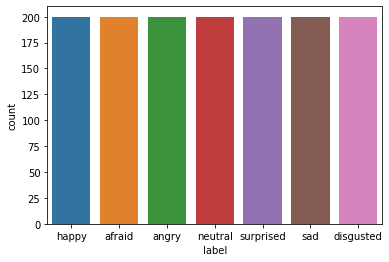

In [67]:
sns.countplot(train['label'])

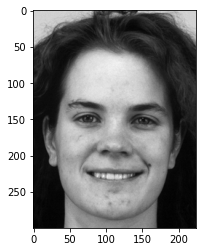

In [68]:
from PIL import Image

# center crop 적용 후, 224 x 300의 크기를 사용
img = Image.open(train['image'][0]).convert("L")
frac = 0.75
left = img.size[0]*((1-frac)/2)
upper = img.size[1]*((1-frac)/2)
right = img.size[0]-((1-frac)/2)*img.size[0]
bottom = img.size[1]-((1-frac)/2)*img.size[1]

cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
plt.imshow(cropped_img, cmap='gray');

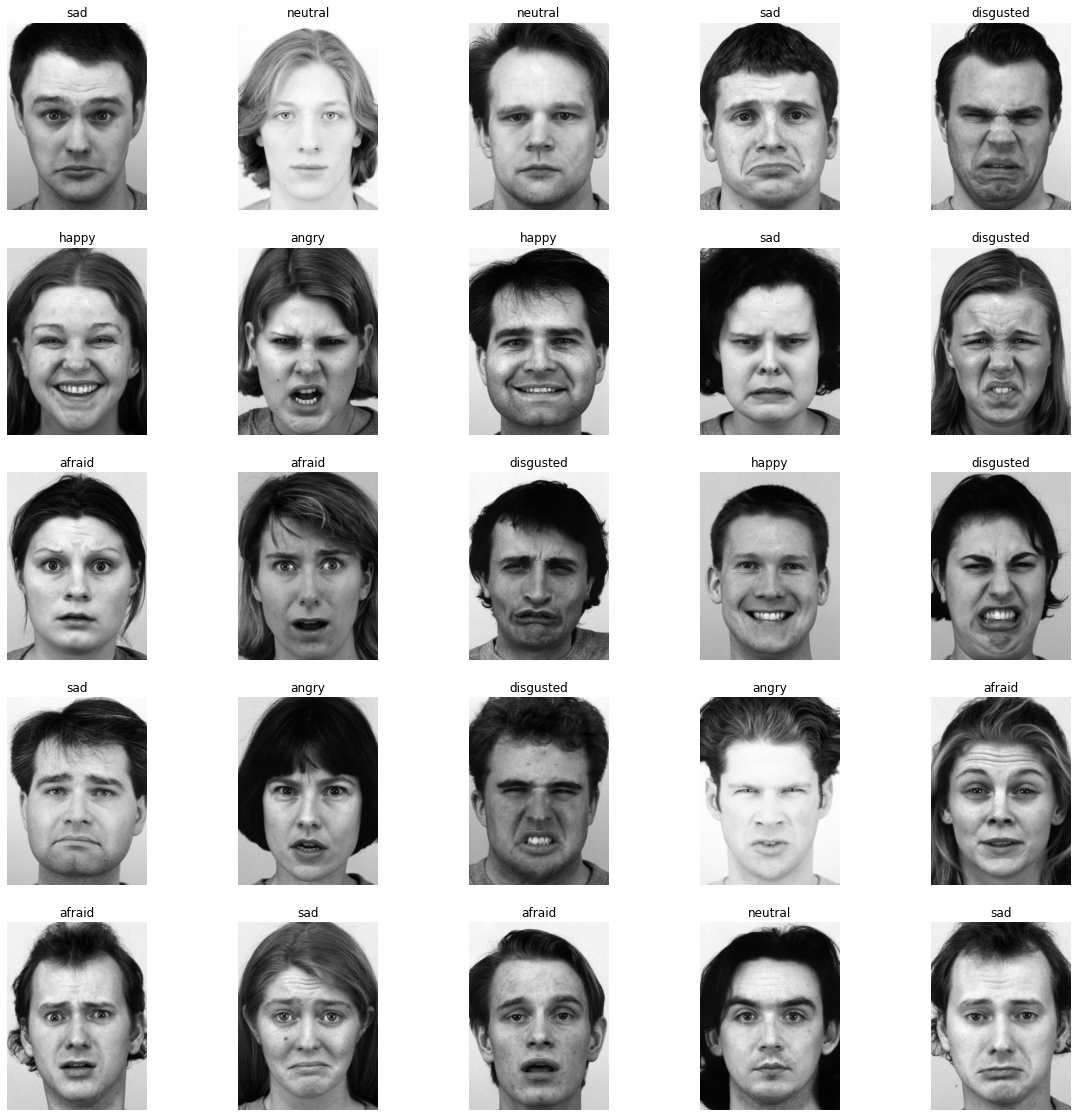

In [ ]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file, grayscale=True)
    cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
    img = np.array(cropped_img)
    plt.imshow(cropped_img, cmap='gray')
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [ ]:
train_features = extract_features(train['image'])

  0%|          | 0/700 [00:00<?, ?it/s]

(700, 300, 224, 1)


In [ ]:
test_features = extract_features(test['image'])

  0%|          | 0/1400 [00:00<?, ?it/s]

(1400, 300, 224, 1)


In [ ]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [ ]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
# one-hot encoding
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [ ]:
print(y_train[0])
print(y_test[0])

[0. 0. 0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0. 0. 0.]


## Model Creation

In [ ]:
# config
input_shape = (300, 224, 1)
output_class = 7

In [ ]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(output_class, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics='accuracy')

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 298, 222, 128)     1280      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 149, 111, 128)    0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 149, 111, 128)     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 147, 109, 256)     295168    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 73, 54, 256)      0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 73, 54, 256)      

In [ ]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
22/22 [==============================] - 15s 662ms/step - loss: 1.9558 - accuracy: 0.1443 - val_loss: 1.9453 - val_accuracy: 0.1443
Epoch 2/100
22/22 [==============================] - 14s 651ms/step - loss: 1.9497 - accuracy: 0.1386 - val_loss: 1.9452 - val_accuracy: 0.1836
Epoch 3/100
22/22 [==============================] - 14s 659ms/step - loss: 1.9519 - accuracy: 0.1343 - val_loss: 1.9452 - val_accuracy: 0.1771
Epoch 4/100
22/22 [==============================] - 14s 667ms/step - loss: 1.9439 - accuracy: 0.1471 - val_loss: 1.9450 - val_accuracy: 0.1500
Epoch 5/100
22/22 [==============================] - 14s 664ms/step - loss: 1.9434 - accuracy: 0.1629 - val_loss: 1.9449 - val_accuracy: 0.1686
Epoch 6/100
22/22 [==============================] - 14s 658ms/step - loss: 1.9346 - accuracy: 0.1629 - val_loss: 1.9446 - val_accuracy: 0.1857
Epoch 7/100
22/22 [==============================] - 19s 873ms/step - loss: 1.9333 - accuracy: 0.1700 - val_loss: 1.9442 - val_accuracy:

## Plot the Results

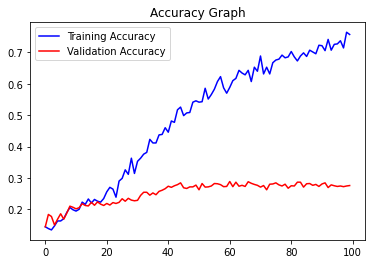

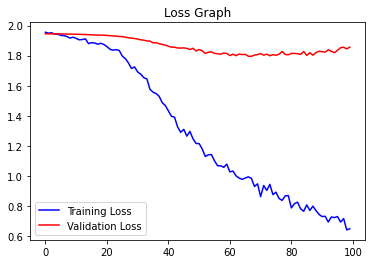

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Save Model

In [ ]:
model.save('fer_straight.h5')

# 👈 👉 Side pose Model 


> 측면 사진만 학습할 모델

---





In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/KDEF_Angle2/Train/side/'

In [ ]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

happy Completed
sad Completed
afraid Completed
surprised Completed
angry Completed
disgusted Completed
neutral Completed
.ipynb_checkpoints Completed


image      label
0  /content/drive/MyDrive/KDEF_Angle2/Train/side/...  surprised
1  /content/drive/MyDrive/KDEF_Angle2/Train/side/...  disgusted
2  /content/drive/MyDrive/KDEF_Angle2/Train/side/...        sad
3  /content/drive/MyDrive/KDEF_Angle2/Train/side/...      happy
4  /content/drive/MyDrive/KDEF_Angle2/Train/side/...        sad

## Exploratory Data Analysis

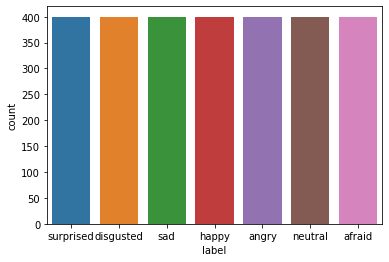

In [ ]:
sns.countplot(train['label'])

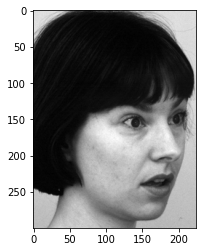

In [ ]:
from PIL import Image

# center crop 적용 후, 224 x 300의 크기를 사용
img = Image.open(train['image'][0]).convert("L")
frac = 0.75
left = img.size[0]*((1-frac)/2)
upper = img.size[1]*((1-frac)/2)
right = img.size[0]-((1-frac)/2)*img.size[0]
bottom = img.size[1]-((1-frac)/2)*img.size[1]

cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
plt.imshow(cropped_img, cmap='gray');

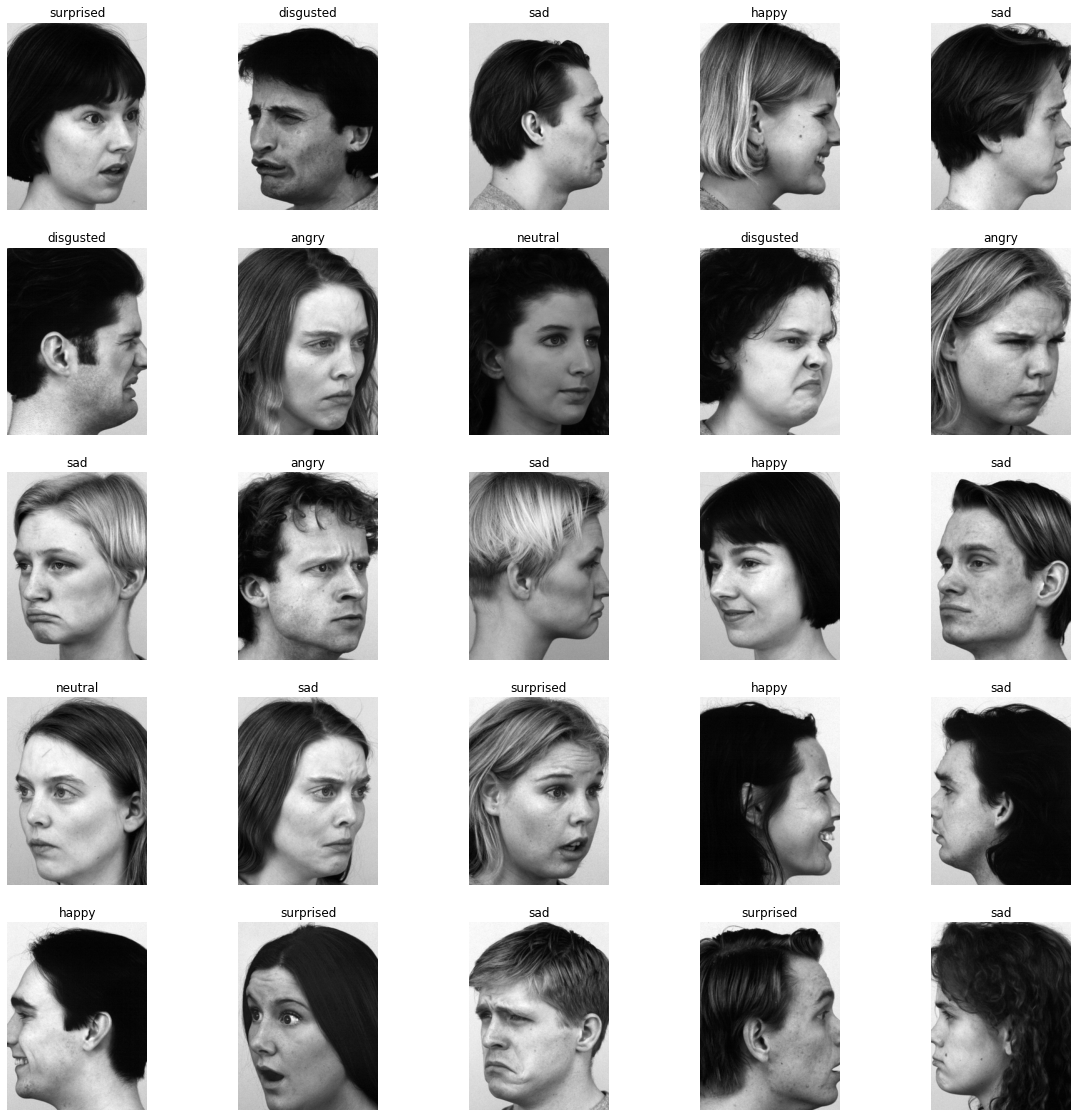

In [ ]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file, grayscale=True)
    cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
    img = np.array(cropped_img)
    plt.imshow(cropped_img, cmap='gray')
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [ ]:
train_features = extract_features(train['image'])

  0%|          | 0/2800 [00:00<?, ?it/s]

(2800, 300, 224, 1)


In [ ]:
test_features = extract_features(test['image'])

  0%|          | 0/1400 [00:00<?, ?it/s]

(1400, 300, 224, 1)


In [ ]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [ ]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
# one-hot encoding
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [ ]:
print(y_train[0])
print(y_test[0])

[0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1. 0. 0.]


## Model Creation

In [ ]:
# config
input_shape = (300, 224, 1)
output_class = 7

In [ ]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(output_class, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics='accuracy')

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 298, 222, 128)     1280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 149, 111, 128)    0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 149, 111, 128)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 147, 109, 256)     295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 73, 54, 256)      0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 73, 54, 256)      

In [ ]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
88/88 [==============================] - 45s 501ms/step - loss: 1.9522 - accuracy: 0.1546 - val_loss: 1.9449 - val_accuracy: 0.1671
Epoch 2/100
88/88 [==============================] - 41s 472ms/step - loss: 1.9458 - accuracy: 0.1471 - val_loss: 1.9444 - val_accuracy: 0.1879
Epoch 3/100
88/88 [==============================] - 42s 479ms/step - loss: 1.9367 - accuracy: 0.1671 - val_loss: 1.9436 - val_accuracy: 0.1921
Epoch 4/100
88/88 [==============================] - 42s 476ms/step - loss: 1.9317 - accuracy: 0.1782 - val_loss: 1.9426 - val_accuracy: 0.1886
Epoch 5/100
88/88 [==============================] - 42s 477ms/step - loss: 1.9294 - accuracy: 0.1821 - val_loss: 1.9414 - val_accuracy: 0.1964
Epoch 6/100
88/88 [==============================] - 42s 476ms/step - loss: 1.9241 - accuracy: 0.1839 - val_loss: 1.9408 - val_accuracy: 0.2107
Epoch 7/100
88/88 [==============================] - 42s 476ms/step - loss: 1.9213 - accuracy: 0.1829 - val_loss: 1.9399 - val_accuracy:

## Plot the Results

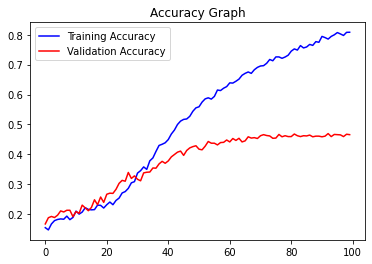

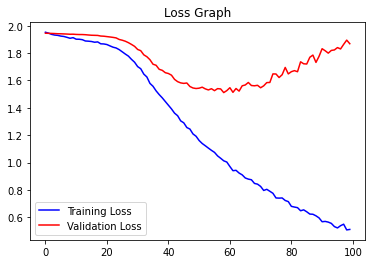

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Save Model

In [ ]:
model.save('fer_side.h5')

# 🎯 Pose classification Model 


> 사진이 정면인지 측면인지 판단하는 모델

---





In [14]:
TRAIN_DIR = '/content/KDEF_Pose_V2/Train/'

In [15]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

side Completed
straight Completed


image     label
0      /content/KDEF_Pose_V2/Train/side/BM22SUHL.JPG      side
1  /content/KDEF_Pose_V2/Train/side/BM32HAFL_AUG.jpg      side
2      /content/KDEF_Pose_V2/Train/side/BF20DIHR.JPG      side
3  /content/KDEF_Pose_V2/Train/straight/BM21AFS_A...  straight
4      /content/KDEF_Pose_V2/Train/side/AM35DIFL.JPG      side

## Exploratory Data Analysis

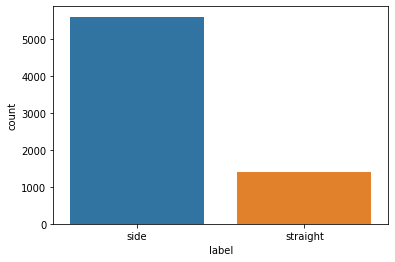

In [16]:
sns.countplot(train['label'])

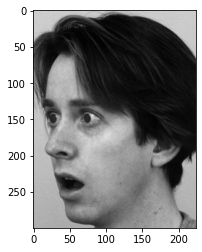

In [17]:
from PIL import Image

# center crop 적용 후, 224 x 300의 크기를 사용
img = Image.open(train['image'][0]).convert("L")
frac = 0.75
left = img.size[0]*((1-frac)/2)
upper = img.size[1]*((1-frac)/2)
right = img.size[0]-((1-frac)/2)*img.size[0]
bottom = img.size[1]-((1-frac)/2)*img.size[1]

cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
plt.imshow(cropped_img, cmap='gray');

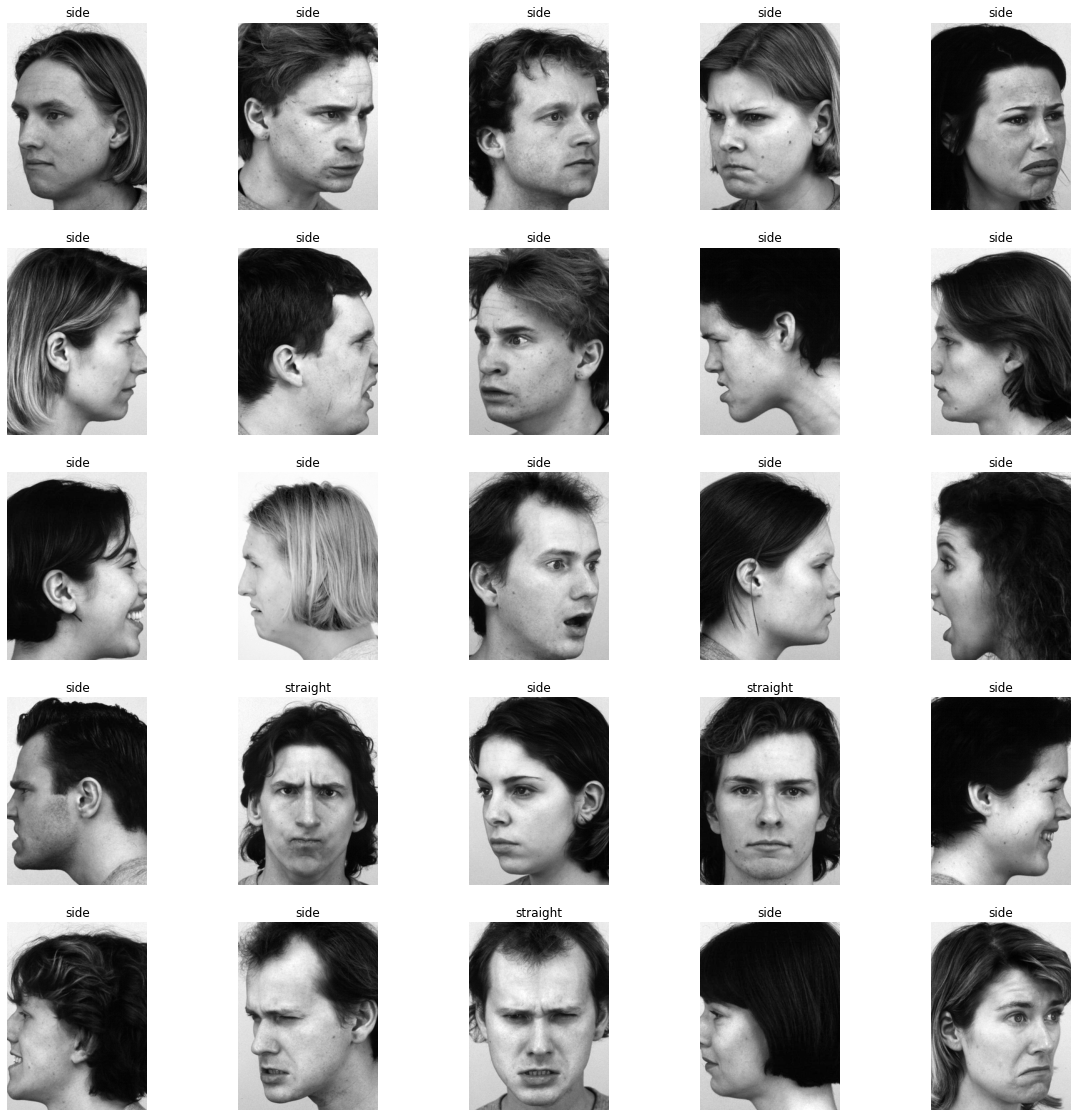

In [18]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file, grayscale=True)
    cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
    img = np.array(cropped_img)
    plt.imshow(cropped_img, cmap='gray')
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [19]:
train_features = extract_features(train['image'])

  0%|          | 0/7000 [00:00<?, ?it/s]

(7000, 300, 224, 1)


In [20]:
test_features = extract_features(pose_test['image'])

  0%|          | 0/2800 [00:00<?, ?it/s]

(2800, 300, 224, 1)


In [21]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [22]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(pose_test['label'])

In [23]:
# one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [24]:
print(y_train[0])
print(y_test[0])

[1. 0.]
[1. 0.]


## Model Creation

In [25]:
# config
input_shape = (300, 224, 1)
output_class = 2

In [26]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(output_class, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics='accuracy')

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 222, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 111, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 149, 111, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 109, 256)     295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 54, 256)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 73, 54, 256)       0

In [27]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
110/110 [==============================] - 28s 152ms/step - loss: 0.4351 - accuracy: 0.8891 - val_loss: 0.0785 - val_accuracy: 0.9671
Epoch 2/5
110/110 [==============================] - 14s 128ms/step - loss: 0.0506 - accuracy: 0.9867 - val_loss: 0.0455 - val_accuracy: 0.9857
Epoch 3/5
110/110 [==============================] - 14s 129ms/step - loss: 0.0059 - accuracy: 0.9976 - val_loss: 0.0298 - val_accuracy: 0.9846
Epoch 4/5
110/110 [==============================] - 14s 128ms/step - loss: 0.0339 - accuracy: 0.9901 - val_loss: 0.0497 - val_accuracy: 0.9889
Epoch 5/5
110/110 [==============================] - 14s 129ms/step - loss: 0.0104 - accuracy: 0.9966 - val_loss: 0.0084 - val_accuracy: 0.9989


## Plot the Results

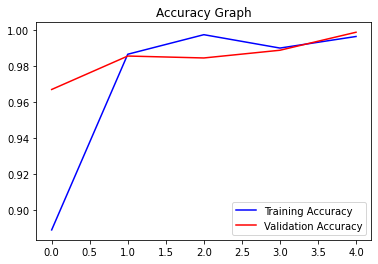

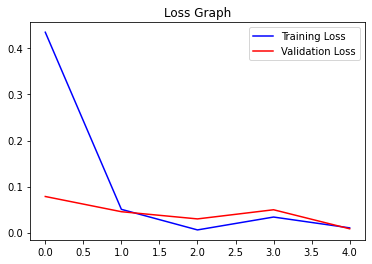

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Save Model

In [30]:
model.save('fer_pose_v2.h5')

In [31]:
!cp fer_pose_v2.h5 /content/drive/MyDrive

# 🏭 Ensemble Model


> 3개의 모델을 앙상블



## Test Feature Extraction

In [32]:
test_features = extract_features(test['image'])

  0%|          | 0/2800 [00:00<?, ?it/s]

(2800, 300, 224, 1)


In [33]:
## normalize the image
x_test = test_features/255.0

In [34]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(test['label'])
y_test = le.transform(test['label'])

In [35]:
## Encoder for Pose
le_pose = LabelEncoder()
le_pose.fit(pose_test['label'])

LabelEncoder()

In [36]:
print(y_test)

[6 6 6 ... 0 0 0]


## Evaluate Ensemble

In [18]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [19]:
model_pose = tf.keras.models.load_model('/content/drive/MyDrive/fer_pose_v2.h5')
model_straight = tf.keras.models.load_model('/content/drive/MyDrive/fer_straight_v2.h5')
model_side = tf.keras.models.load_model('/content/drive/MyDrive/fer_side_v2.h5')

In [20]:
models = [model_pose, model_straight, model_side]

In [21]:
def predict_pose(model_pose, test_x):
    pred = model_pose.predict(test_x, verbose = 0)
    prediction_label = le_pose.inverse_transform([pred.argmax()])[0]
    return prediction_label

In [22]:
def predict_emotion_straight(model_straight, test_x):
    # make predictions
    yhats = model_straight.predict(test_x, verbose = 0)
    yhats = np.array(yhats)
    # argmax across classes
    result = np.argmax(yhats, axis=1)
    return result

In [23]:
def predict_emotion_side(model_side, test_x):
    # make predictions
    yhats = model_side.predict(test_x, verbose = 0)
    yhats = np.array(yhats)
    # argmax across classes
    result = np.argmax(yhats, axis=1)
    return result

In [24]:
def evaluate_ensemble_model(models, test_x, test_y):
    # make prediction
    yhat = []
    for testData in tqdm(test_x):
        pose = predict_pose(models[0], testData.reshape(1, 300, 224, 1))
        
        if pose == "straight":
            yhat.extend(predict_emotion_straight(models[1], testData.reshape(1, 300, 224, 1)))
        elif pose == "side":
            yhat.extend(predict_emotion_side(models[2], testData.reshape(1, 300, 224, 1)))
    # calculate accuracy (answer, prediction)
    return accuracy_score(test_y, yhat)

In [44]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 2800/2800 [03:54<00:00, 11.95it/s]


In [45]:
print(f'Accuracy : {score}')

Accuracy : 0.5471428571428572


# Evaluate Model with Side Image

In [ ]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_SIDE)
test.head()

neutral Completed
surprised Completed
disgusted Completed
sad Completed
angry Completed
happy Completed
afraid Completed


image    label
0  /content/drive/MyDrive/KDEF_SIDE/neutral/AF01N...  neutral
1  /content/drive/MyDrive/KDEF_SIDE/neutral/AF02N...  neutral
2  /content/drive/MyDrive/KDEF_SIDE/neutral/AF02N...  neutral
3  /content/drive/MyDrive/KDEF_SIDE/neutral/AF01N...  neutral
4  /content/drive/MyDrive/KDEF_SIDE/neutral/AF01N...  neutral

In [ ]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

  0%|          | 0/1120 [00:00<?, ?it/s]

(1120, 300, 224, 1)


In [ ]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(test['label'])
y_test = le.transform(test['label'])

In [ ]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 1120/1120 [01:47<00:00, 10.45it/s]


In [ ]:
print(f'Accuracy : {score}')

Accuracy : 0.50625


# Evaluate Model Only with Angle

In [25]:
%cd /content

!unzip -qq "/content/drive/MyDrive/KDEF_TEST_FullLeft_V2.zip"

/content


In [26]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_HalfLeft_V2.zip"

In [27]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Straight_V2.zip"

In [28]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_HalfRight_V2.zip"

In [29]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_FullRight_V2.zip"

## Full Left

In [30]:
TEST_DIR_FullLeft = '/content/KDEF_TEST_FullLeft_V2/'

In [31]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_FullLeft)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0  /content/KDEF_TEST_FullLeft_V2/surprised/BF08S...  surprised
1  /content/KDEF_TEST_FullLeft_V2/surprised/BM07S...  surprised
2  /content/KDEF_TEST_FullLeft_V2/surprised/AM06S...  surprised
3  /content/KDEF_TEST_FullLeft_V2/surprised/BM08S...  surprised
4  /content/KDEF_TEST_FullLeft_V2/surprised/BF04S...  surprised

In [32]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 560/560 [00:06<00:00, 82.08it/s]


(560, 300, 224, 1)


In [33]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(test['label'])
y_test = le.transform(test['label'])

In [34]:
## Encoder for Pose
le_pose = LabelEncoder()
le_pose.fit(pose_test['label'])

LabelEncoder()

In [35]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 560/560 [01:10<00:00,  7.98it/s]


In [36]:
print(f'Accuracy : {score}')

Accuracy : 0.5


## Half Left

In [38]:
TEST_DIR_HalfLeft = '/content/KDEF_TEST_HalfLeft_V2/'

In [39]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_HalfLeft)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0  /content/KDEF_TEST_HalfLeft_V2/surprised/BF05S...  surprised
1  /content/KDEF_TEST_HalfLeft_V2/surprised/BF03S...  surprised
2  /content/KDEF_TEST_HalfLeft_V2/surprised/AF03S...  surprised
3  /content/KDEF_TEST_HalfLeft_V2/surprised/AM02S...  surprised
4  /content/KDEF_TEST_HalfLeft_V2/surprised/BF08S...  surprised

In [40]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 560/560 [00:05<00:00, 111.33it/s]


(560, 300, 224, 1)


In [41]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(test['label'])
y_test = le.transform(test['label'])

In [42]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 560/560 [00:57<00:00,  9.74it/s]


In [43]:
print(f'Accuracy : {score}')

Accuracy : 0.6125


## Straight

In [44]:
TEST_DIR_Straight = '/content/KDEF_TEST_Straight_V2/'

In [45]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Straight)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0  /content/KDEF_TEST_Straight_V2/surprised/AM04S...  surprised
1  /content/KDEF_TEST_Straight_V2/surprised/BM08S...  surprised
2  /content/KDEF_TEST_Straight_V2/surprised/AM02S...  surprised
3  /content/KDEF_TEST_Straight_V2/surprised/BM07S...  surprised
4  /content/KDEF_TEST_Straight_V2/surprised/AF08S...  surprised

In [46]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 560/560 [00:05<00:00, 109.09it/s]


(560, 300, 224, 1)


In [47]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(test['label'])
y_test = le.transform(test['label'])

In [48]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 560/560 [00:58<00:00,  9.59it/s]


In [49]:
print(f'Accuracy : {score}')

Accuracy : 0.5125


## Half Right

In [50]:
TEST_DIR_HalfRight = '/content/KDEF_TEST_HalfRight_V2/'

In [51]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_HalfRight)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0  /content/KDEF_TEST_HalfRight_V2/surprised/BM05...  surprised
1  /content/KDEF_TEST_HalfRight_V2/surprised/BF05...  surprised
2  /content/KDEF_TEST_HalfRight_V2/surprised/BM09...  surprised
3  /content/KDEF_TEST_HalfRight_V2/surprised/BF03...  surprised
4  /content/KDEF_TEST_HalfRight_V2/surprised/BM06...  surprised

In [52]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 560/560 [00:05<00:00, 111.64it/s]


(560, 300, 224, 1)


In [53]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(test['label'])
y_test = le.transform(test['label'])

In [54]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 560/560 [01:03<00:00,  8.84it/s]


In [55]:
print(f'Accuracy : {score}')

Accuracy : 0.6142857142857143


## Full Right

In [56]:
TEST_DIR_FullRight = '/content/KDEF_TEST_FullRight_V2/'

In [57]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_FullRight)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0  /content/KDEF_TEST_FullRight_V2/surprised/BF03...  surprised
1  /content/KDEF_TEST_FullRight_V2/surprised/AF01...  surprised
2  /content/KDEF_TEST_FullRight_V2/surprised/AM05...  surprised
3  /content/KDEF_TEST_FullRight_V2/surprised/AM02...  surprised
4  /content/KDEF_TEST_FullRight_V2/surprised/AM10...  surprised

In [58]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 560/560 [00:04<00:00, 112.38it/s]


(560, 300, 224, 1)


In [59]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(test['label'])
y_test = le.transform(test['label'])

In [60]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 560/560 [00:57<00:00,  9.74it/s]


In [61]:
print(f'Accuracy : {score}')

Accuracy : 0.49642857142857144


# Evaluate Model Only with Emotion

In [37]:
%cd /content

!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Afraid_V2.zip"

/content


In [38]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Angry_V2.zip"

In [39]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Disgusted_V2.zip"

In [40]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Happy_V2.zip"

In [41]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Neutral_V2.zip"

In [42]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Sad_V2.zip"

In [43]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Surprised_V2.zip"

## Afraid

In [69]:
TEST_DIR_Afraid = '/content/KDEF_TEST_Afraid_V2/'

In [70]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Afraid)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image   label
0  /content/KDEF_TEST_Afraid_V2/afraid/BF06AFS_AU...  afraid
1   /content/KDEF_TEST_Afraid_V2/afraid/AM07AFHR.JPG  afraid
2  /content/KDEF_TEST_Afraid_V2/afraid/BF08AFHR_A...  afraid
3   /content/KDEF_TEST_Afraid_V2/afraid/AM07AFHL.JPG  afraid
4  /content/KDEF_TEST_Afraid_V2/afraid/AM04AFHL_A...  afraid

In [71]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

  0%|          | 0/400 [00:00<?, ?it/s]

(400, 300, 224, 1)


In [72]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [73]:
score = evaluate_ensemble_model(models, x_test, y_test)

  0%|          | 0/400 [00:00<?, ?it/s]

In [74]:
print(f'Accuracy : {score}')

Accuracy : 0.25


## Angry

In [75]:
TEST_DIR_Angry = '/content/KDEF_TEST_Angry_V2/'

In [76]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Angry)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image  label
0     /content/KDEF_TEST_Angry_V2/angry/BF08ANHL.JPG  angry
1  /content/KDEF_TEST_Angry_V2/angry/BF06ANFL_AUG...  angry
2     /content/KDEF_TEST_Angry_V2/angry/AF02ANFR.JPG  angry
3     /content/KDEF_TEST_Angry_V2/angry/AM04ANFL.JPG  angry
4  /content/KDEF_TEST_Angry_V2/angry/AF10ANFR_AUG...  angry

In [77]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

  0%|          | 0/400 [00:00<?, ?it/s]

(400, 300, 224, 1)


In [78]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [79]:
score = evaluate_ensemble_model(models, x_test, y_test)

  0%|          | 0/400 [00:00<?, ?it/s]

In [80]:
print(f'Accuracy : {score}')

Accuracy : 0.63


## Disgusted

In [81]:
TEST_DIR_Disgusted = '/content/KDEF_TEST_Disgusted_V2/'

In [82]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Disgusted)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0  /content/KDEF_TEST_Disgusted_V2/disgusted/AF07...  disgusted
1  /content/KDEF_TEST_Disgusted_V2/disgusted/BF08...  disgusted
2  /content/KDEF_TEST_Disgusted_V2/disgusted/AF09...  disgusted
3  /content/KDEF_TEST_Disgusted_V2/disgusted/BM08...  disgusted
4  /content/KDEF_TEST_Disgusted_V2/disgusted/BF04...  disgusted

In [83]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

  0%|          | 0/400 [00:00<?, ?it/s]

(400, 300, 224, 1)


In [84]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [85]:
score = evaluate_ensemble_model(models, x_test, y_test)

  0%|          | 0/400 [00:00<?, ?it/s]

In [86]:
print(f'Accuracy : {score}')

Accuracy : 0.615


## Happy

In [87]:
TEST_DIR_Happy= '/content/KDEF_TEST_Happy_V2/'

In [88]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Happy)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image  label
0      /content/KDEF_TEST_Happy_V2/happy/AM07HAS.JPG  happy
1  /content/KDEF_TEST_Happy_V2/happy/BM03HAFL_AUG...  happy
2     /content/KDEF_TEST_Happy_V2/happy/BM06HAHR.JPG  happy
3     /content/KDEF_TEST_Happy_V2/happy/AM10HAHR.JPG  happy
4  /content/KDEF_TEST_Happy_V2/happy/AM01HAS_AUG.jpg  happy

In [89]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

  0%|          | 0/400 [00:00<?, ?it/s]

(400, 300, 224, 1)


In [90]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [91]:
score = evaluate_ensemble_model(models, x_test, y_test)

  0%|          | 0/400 [00:00<?, ?it/s]

In [92]:
print(f'Accuracy : {score}')

Accuracy : 0.785


## Neutral

In [93]:
TEST_DIR_Neutral = '/content/KDEF_TEST_Neutral_V2/'

In [94]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Neutral)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image    label
0  /content/KDEF_TEST_Neutral_V2/neutral/AM07NEHL...  neutral
1  /content/KDEF_TEST_Neutral_V2/neutral/BM04NEFR...  neutral
2  /content/KDEF_TEST_Neutral_V2/neutral/BF10NES.JPG  neutral
3  /content/KDEF_TEST_Neutral_V2/neutral/BM01NEHR...  neutral
4  /content/KDEF_TEST_Neutral_V2/neutral/BF07NEHR...  neutral

In [95]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

  0%|          | 0/400 [00:00<?, ?it/s]

(400, 300, 224, 1)


In [96]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [97]:
score = evaluate_ensemble_model(models, x_test, y_test)

  0%|          | 0/400 [00:00<?, ?it/s]

In [98]:
print(f'Accuracy : {score}')

Accuracy : 0.5625


## Sad

In [99]:
TEST_DIR_Sad = '/content/KDEF_TEST_Sad_V2/'

In [100]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Sad)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image label
0  /content/KDEF_TEST_Sad_V2/sad/BF06SAHR_AUG.jpg   sad
1  /content/KDEF_TEST_Sad_V2/sad/AF01SAHL_AUG.jpg   sad
2      /content/KDEF_TEST_Sad_V2/sad/BF05SAHR.JPG   sad
3   /content/KDEF_TEST_Sad_V2/sad/BF01SAS_AUG.jpg   sad
4  /content/KDEF_TEST_Sad_V2/sad/BM09SAFL_AUG.jpg   sad

In [101]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

  0%|          | 0/400 [00:00<?, ?it/s]

(400, 300, 224, 1)


In [102]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [103]:
score = evaluate_ensemble_model(models, x_test, y_test)

  0%|          | 0/400 [00:00<?, ?it/s]

In [104]:
print(f'Accuracy : {score}')

Accuracy : 0.3525


## Surprised

In [105]:
TEST_DIR_Surprised = '/content/KDEF_TEST_Surprised_V2/'

In [106]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Surprised)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


image      label
0  /content/KDEF_TEST_Surprised_V2/surprised/BF03...  surprised
1  /content/KDEF_TEST_Surprised_V2/surprised/AM04...  surprised
2  /content/KDEF_TEST_Surprised_V2/surprised/BM05...  surprised
3  /content/KDEF_TEST_Surprised_V2/surprised/AF01...  surprised
4  /content/KDEF_TEST_Surprised_V2/surprised/BF08...  surprised

In [107]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

  0%|          | 0/400 [00:00<?, ?it/s]

(400, 300, 224, 1)


In [108]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [109]:
score = evaluate_ensemble_model(models, x_test, y_test)

  0%|          | 0/400 [00:00<?, ?it/s]

In [110]:
print(f'Accuracy : {score}')

Accuracy : 0.635
